In [2]:
import numpy as np
import os
import mne
import pandas as pd
import hmp 
import matplotlib.pyplot as plt
from pycrostates.cluster import ModKMeans
import random

### HMP Fitting Function

In [3]:
def extract_timecourse_one_session(files, session_str, tmin, n_comp, location):
    """
    Extracts, preprocesses, and fits HMP models for a single session across multiple subjects.

    Parameters:
    - files (list of str): List of file names containing EEG data (e.g., .fif files).
    - session_str (str): String used to identify files corresponding to the session of interest.

    Returns:
    - models_dict (dict): Dictionary mapping subject IDs to their corresponding:
        - 'model': fitted HMP model object
        - 'epoch_data': preprocessed epoch-level data
        - 'init': initialization of model

    Notes:
    - Filters annotations to include only events corresponding to start and end of trial (reasoning part of experiment)
    - Applies HMP model fitting per subject.
    """
    models_dict = {}

    for file in files: 
        if session_str in file.split('_')[1][2:4]:
            print(f"Processing file: {file}")
            
            # 1. Read data
            raw = mne.io.read_raw_fif(os.path.join(epoch_data_path, file), preload=True)

           # 2. Extract annotations
            annotations = raw.annotations
            onset = annotations.onset
            description = annotations.description

            # 3. Create dataframe
            df = pd.DataFrame({"description": description, "onset": onset})

            # 4. Filter events
            df_filtered = df[df["description"].isin(["stim-all_stim", "trial_end"])].reset_index(drop=True)

            # 5. Map to event IDs
            mapping = {"stim-all_stim": 1, "trial_end": 2}
            df_filtered["event_id"] = df_filtered["description"].map(mapping)

            # 6. Convert to samples
            sfreq = int(raw.info['sfreq'])
            df_filtered["sample"] = (df_filtered["onset"] * sfreq).astype(int)

            # 7. Create previous column
            df_filtered["previous"] = 0

            # 8. Arrange columns
            df_events = df_filtered[["sample", "previous", "event_id"]]

            # 9. Convert to numpy
            events = df_events.values

            # 10. Define IDs
            event_id = {"stimulus": 1}
            resp_id = {"response": 2}

            # 11. Epoch data
            epoch_data = hmp.utils.read_mne_data(
                os.path.join(epoch_data_path, file),
                event_id=event_id,
                resp_id=resp_id,
                sfreq=500,
                events_provided=events,
                verbose=True,
                tmin=tmin,
                tmax=15
            )
            

            # 12. Transform data
            hmp_data = hmp.utils.transform_data(epoch_data, apply_standard=False, n_comp=n_comp)

            # 13. Initialize model
            model_init = hmp.models.hmp(
                data=hmp_data,
                sfreq=epoch_data.sfreq,
                cpus=4,
                event_width=50,
                distribution='gamma',
                shape=2,
                location=location
            )

            # 14. Fit model
            model = model_init.fit(verbose=False)

            # 15. Store in dictionary
            subject_id = "subject_" + file.split('_')[1][0:2]
            print(f"✅ Storing data for {subject_id}")

            models_dict[subject_id] = {
                "model": model,
                "epoch_data": epoch_data,
                "init": model_init
            }

    return models_dict

### Microstate Analysis Pipeline

In [4]:
# -------------------------------
# Concatenate trials into continuous Raw objects
# -------------------------------

def concatenate_raw_data(models_dict, info):
    """
    Concatenates trials into continuous MNE Raw objects for each subject. 
    Only EEG data relating to the reasoning phase is kept (encoding phase excluded), 
    and the inter-trial interval has been removed.
    
    Args:
        models_dict (dict): Dictionary where keys are subject IDs and values are dicts 
                            containing "epoch_data" (xarray with trial EEG data).
        info (mne.Info): MNE info object containing session metadata 

    Returns:
        dict: Dictionary mapping each subject ID to a concatenated MNE Raw object.
    """
    raw_combined_dict = {}

    for subject in models_dict:
        model_info = models_dict[subject]  
        epoch_data = model_info["epoch_data"]  

        # Concatenate trials
        raw_combined_list = []

        for trial in epoch_data.data[0].values:
            # trial is (n_channels, n_samples)
            valid_mask = ~np.isnan(trial).all(axis=0)  # remove columns that are all NaN
            trimmed = trial[:, valid_mask]

            # Convert to MNE Raw object
            raw = mne.io.RawArray(trimmed, info, verbose=False)
            raw_combined_list.append(raw)

        # Combine all Raw objects into one continuous recording
        raw_combined = mne.concatenate_raws(raw_combined_list)
        raw_combined_dict[subject] = raw_combined

    return raw_combined_dict

# -------------------------------
# Perform microstate analysis (ModKMeans clustering)
# -------------------------------

def perform_microstate_analysis(raw_combined_dict, n_clusters):
    """
    Performs microstate analysis using the modified k-means (ModKMeans) algorithm on concatenated EEG data.

    Args:
        raw_combined_dict (dict): Dictionary mapping each subject ID to a concatenated MNE Raw object.
        n_clusters (int): Number of microstate clusters to extract.

    Returns:
        dict: Dictionary mapping each subject ID to a fitted ModKMeans model.
    """
    ModK_dict = {}

    for subject in raw_combined_dict:
        raw_combined = raw_combined_dict[subject]

        # Initialize and fit model
        ModK = ModKMeans(n_clusters=n_clusters, random_state=42)
        ModK.fit(raw_combined, n_jobs=4, verbose="WARNING")

        # Store fitted model
        ModK_dict[subject] = ModK

        print(f"✅ Done with microstate analysis for subject: {subject}\n") 

    return ModK_dict

### Event Timing Analysis and Helper Function For Subsequent Analysis

In [5]:
# -------------------------------
# Absolute timing (list) for one event
# -------------------------------

def event_abs_timing_list(eventprobs, event_n):
    """
    For a given event number, finds the time point in each trial where the event has the highest probability.

    Args:
        eventprobs: 3D array (trials × samples × events), probabilities for each event over time.
        event_n: Integer index of the event of interest.

    Returns:
        List of time indices (one per trial) where the given event is most probable (in sample indices).
    """
    trial_results = []

    for trial in range(len(eventprobs)):
        trial_probs = [eventprobs[trial][sample][event_n] for sample in range(len(eventprobs[trial]))]
        max_idx = trial_probs.index(max(trial_probs))
        trial_results.append(max_idx)

    return trial_results

# -------------------------------
# Absolute timing (DataFrame) for all events
# -------------------------------

def event_abs_timing_df(eventprobs, n_events):
    """
    Constructs a DataFrame showing, for each event, the sample index at which that event
    had the highest probability across trials.

    Args:
        eventprobs: 3D array (trials × samples × events), probabilities for each event over time.
        n_events: Integer, number of events.

    Returns:
        DataFrame of shape (trials × events), with each entry being the sample index of peak probability.
    """
    abs_timing_dict = {}

    for event in range(n_events):
        abs_timing_list = event_abs_timing_list(eventprobs, event)
        abs_timing_dict[event] = abs_timing_list

    return pd.DataFrame(abs_timing_dict)

# -------------------------------
# Relative timing (list) for one event
# -------------------------------

def event_rel_timing_list(eventprobs, rt, event_n):
    """
    Calculate the relative timing of a specific event within each trial,
    expressed as a proportion of the reaction time.

    Args:
        eventprobs: 3D array (trials × samples × events), probabilities for each event over time.
        rt: List of reaction times (in seconds), one per trial.
        event_n: Integer index of the event of interest.

    Returns:
        List of relative timings (one per trial).
    """
    trial_results = []

    for trial in range(len(eventprobs)):
        trial_probs = [eventprobs[trial][sample][event_n] for sample in range(len(eventprobs[trial]))]
        max_idx = trial_probs.index(max(trial_probs))

        # Convert sample index to milliseconds (500 Hz = 2 ms per sample)
        event_ms = max_idx * 2
        rt_ms = rt[trial] * 1000

        trial_results.append(event_ms / rt_ms)

    return trial_results

# -------------------------------
# Relative timing (DataFrame) for all events
# -------------------------------

def event_rel_timing_df(eventprobs, rt, n_events):
    """
    Constructs a DataFrame showing, for each event, the relative timing (as a proportion of total trial duration)
    at which that event had the highest probability across trials.

    Args:
        eventprobs: 3D array (trials × samples × events), probabilities for each event over time.
        rt: List or array of reaction times (in seconds), one per trial.
        n_events: Integer, number of events.

    Returns:
        DataFrame with shape (trials x events), with each value being the relative timing of peak probability.
    """
    rel_timing_dict = {}

    for event in range(n_events):
        rel_timing_list = event_rel_timing_list(eventprobs, rt, event)
        rel_timing_dict[event] = rel_timing_list

    return pd.DataFrame(rel_timing_dict)

In [6]:
# -------------------------------
# Average EEG topomap for a single event
# -------------------------------

def average_map_for_event(event_timing_list, epoch_data):
    """
    Computes the average topographic map at given event timepoints across all trials.

    Args:
        event_timing_list: List of sample indices per trial for the event.
        epoch_data: Xarray with dimensions (participants x epochs × channels × samples).
    
    Returns:
        1D numpy array representing the average topographic map (mean over trials).
    """
    all_maps = []
    for idx, sample_idx in enumerate(event_timing_list):
        # index [0] removes the participant dimension (only one participant processed at a time)
        values = epoch_data.isel(epochs=idx, samples=sample_idx).data.values[0]
        all_maps.append(values)
    
    all_maps_array = np.array(all_maps)
    avg_map = np.mean(all_maps_array, axis=0)
    return avg_map

### HMP x Microstate Comparison: Significance Test of Spatial Correlation

In [7]:
# -------------------------------
# Compute correlations between events and cluster maps
# -------------------------------

def compute_event_cluster_correlations(eventprobs, n_events, cluster_maps, epoch_data):
    """
    Computes the spatial correlation between each event's average topographic map and a set
    of cluster (microstate) maps.

    Args:
        eventprobs: Array of event probabilities with shape (trials x timepoints x events).
        n_events: Number of HMP events.
        cluster_maps: List of 1D numpy arrays (microstate cluster map).
        epoch_data: Xarray with dimensions (participants x epochs × channels × samples).

    Returns:
        DataFrame of shape (n_clusters × n_events) with spatial correlations.
    """
    corr_dict = {}

    for event_n in range(n_events):
        # Get sample index of peak probability per trial
        event_timing_list = event_abs_timing_list(eventprobs, event_n)

        # Compute average topographic map across trials
        avg_map = average_map_for_event(event_timing_list, epoch_data)

        # Correlate with each cluster map
        event_corrs = []
        for cluster_map in cluster_maps: 
            corr = np.corrcoef(cluster_map, avg_map)[0, 1]
            event_corrs.append(corr)

        corr_dict[f'event_{event_n}'] = event_corrs

    return pd.DataFrame(corr_dict, index=[f'cluster_{i}' for i in range(len(cluster_maps))])


# -------------------------------
# Generate null distribution of event–cluster correlations
# -------------------------------

def generate_null_distribution(event_rel_timing_df, epoch_data, cluster_maps, n_permutations):
    """
    Generates a null distribution of spatial correlations by randomly permuting event timings
    and comparing the random average maps to the cluster maps

    Args:
        event_rel_timing_df: DataFrame with relative event timings (0–1) per trial and event.
        epoch_data: Xarray with dimensions (participants x epochs × channels × samples), including .rt values in seconds.
        cluster_maps: List of 1D numpy arrays (microstate cluster map).
        n_permutations: Number of permutations to generate.

    Returns:
        List of DataFrames: each contains spatial correlations (clusters × events) for one permutation.
    """
    results = []

    for perm in range(n_permutations):
        perm_corr_dict = {}

        for event in event_rel_timing_df.columns:
            # Get and shuffle the relative timing list
            rel_timing_list = event_rel_timing_df[event].tolist()
            random.shuffle(rel_timing_list)

            sample_indices = []
            for idx, rel_time in enumerate(rel_timing_list):
                rt_ms = epoch_data.rt.values[idx] * 1000
                sample_idx = round(rel_time * rt_ms * 0.5)  # 500 Hz = 0.5 samples/ms
                sample_indices.append(sample_idx)

            # Compute average map at shuffled timepoints
            avg_map = average_map_for_event(sample_indices, epoch_data)

            # Correlate with cluster maps
            perm_corrs = []
            for cluster_map in cluster_maps:
                corr = np.corrcoef(cluster_map, avg_map)[0, 1]
                perm_corrs.append(corr)

            perm_corr_dict[f'event_{event}'] = perm_corrs

        permuted_df = pd.DataFrame(perm_corr_dict, index=[f'cluster_{i}' for i in range(len(cluster_maps))])
        results.append(permuted_df)

    return results
    
# -------------------------------
# Compute significance of event–cluster correlations
# -------------------------------

def compute_event_cluster_significance(observed_df, permuted_dfs):
    """
    Computes two-tailed p-values comparing observed event-cluster correlations
    to a null distribution.

    Args:
        observed_df: DataFrame of observed correlations (clusters × events).
        permuted_dfs: List of DataFrames from permutations (same shape as observed_df).

    Returns:
        p_values_df: DataFrame of p-values (same shape as input).
    """

    # Stack permuted results: shape (n_permutations, n_clusters, n_events)
    null_matrix = np.stack([df.values for df in permuted_dfs], axis=0)

    # Observed values: shape (n_clusters, n_events)
    obs_matrix = observed_df.values

    # Two-tailed p-values: proportion of permuted values as or more extreme than observed
    p_values = (np.abs(null_matrix) >= np.abs(obs_matrix[None, :, :])).mean(axis=0)

    p_df = pd.DataFrame(p_values, index=observed_df.index, columns=observed_df.columns)

    return p_df

# HMP Events vs. Microstate Cluster Maps - Analysis of Spatial Similarity

In [8]:
# -------------------------------
# Load data and path
# -------------------------------
epoch_data_path = os.path.join(os.getcwd())
files = [x for x in os.listdir(epoch_data_path) if "preprocessed-raw.fif" in x]

In [9]:
# -------------------------------
# HMP fitting
# -------------------------------
models_third_session = extract_timecourse_one_session(files, "03", -0.2, 10, 50)

Processing file: subj_0203_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0203_preprocessed-raw.fif...
    Range : 0 ... 2918399 =      0.000 ...  1425.000 secs
Ready.
Reading 0 ... 2918399  =      0.000 ...  1425.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0203_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0203_preprocessed-raw.fif...
    Range : 0 ... 2918399 =      0.000 ...  1425.000 secs
Ready.
Reading 0 ... 2918399  =      0.000 ...  1425.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 165.16 Hz
- Upper tra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0203_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/879 [00:00<?, ?it/s]

✅ Storing data for subject_02
Processing file: subj_0403_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0403_preprocessed-raw.fif...
    Range : 0 ... 2779135 =      0.000 ...  1357.000 secs
Ready.
Reading 0 ... 2779135  =      0.000 ...  1357.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0403_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0403_preprocessed-raw.fif...
    Range : 0 ... 2779135 =      0.000 ...  1357.000 secs
Ready.
Reading 0 ... 2779135  =      0.000 ...  1357.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0403_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/976 [00:00<?, ?it/s]

✅ Storing data for subject_04
Processing file: subj_0503_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0503_preprocessed-raw.fif...
    Range : 0 ... 2836479 =      0.000 ...  1385.000 secs
Ready.
Reading 0 ... 2836479  =      0.000 ...  1385.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0503_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0503_preprocessed-raw.fif...
    Range : 0 ... 2836479 =      0.000 ...  1385.000 secs
Ready.
Reading 0 ... 2836479  =      0.000 ...  1385.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0503_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1832 [00:00<?, ?it/s]

✅ Storing data for subject_05
Processing file: subj_0603_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0603_preprocessed-raw.fif...
    Range : 0 ... 3172351 =      0.000 ...  1549.000 secs
Ready.
Reading 0 ... 3172351  =      0.000 ...  1549.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0603_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0603_preprocessed-raw.fif...
    Range : 0 ... 3172351 =      0.000 ...  1549.000 secs
Ready.
Reading 0 ... 3172351  =      0.000 ...  1549.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0603_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1871 [00:00<?, ?it/s]

✅ Storing data for subject_06
Processing file: subj_0803_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0803_preprocessed-raw.fif...
    Range : 0 ... 2725887 =      0.000 ...  1331.000 secs
Ready.
Reading 0 ... 2725887  =      0.000 ...  1331.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0803_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0803_preprocessed-raw.fif...
    Range : 0 ... 2725887 =      0.000 ...  1331.000 secs
Ready.
Reading 0 ... 2725887  =      0.000 ...  1331.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0803_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/720 [00:00<?, ?it/s]

C:\Users\celia\AppData\Local\Programs\Python\Python313\Lib\site-packages\hmp\models.py:782: RuntimeWarning: invalid value encountered in scalar divide
  if i >= min_iteration and (np.isneginf(lkh) or tolerance > (lkh-lkh_prev)/np.abs(lkh_prev)):
C:\Users\celia\AppData\Local\Programs\Python\Python313\Lib\site-packages\hmp\models.py:782: RuntimeWarning: invalid value encountered in scalar divide
  if i >= min_iteration and (np.isneginf(lkh) or tolerance > (lkh-lkh_prev)/np.abs(lkh_prev)):
C:\Users\celia\AppData\Local\Programs\Python\Python313\Lib\site-packages\hmp\models.py:782: RuntimeWarning: invalid value encountered in scalar divide
  if i >= min_iteration and (np.isneginf(lkh) or tolerance > (lkh-lkh_prev)/np.abs(lkh_prev)):


✅ Storing data for subject_08
Processing file: subj_0903_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0903_preprocessed-raw.fif...
    Range : 0 ... 3944447 =      0.000 ...  1926.000 secs
Ready.
Reading 0 ... 3944447  =      0.000 ...  1926.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0903_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0903_preprocessed-raw.fif...
    Range : 0 ... 3944447 =      0.000 ...  1926.000 secs
Ready.
Reading 0 ... 3944447  =      0.000 ...  1926.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0903_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/560 [00:00<?, ?it/s]

✅ Storing data for subject_09
Processing file: subj_1003_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1003_preprocessed-raw.fif...
    Range : 0 ... 2246655 =      0.000 ...  1097.000 secs
Ready.
Reading 0 ... 2246655  =      0.000 ...  1097.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1003_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1003_preprocessed-raw.fif...
    Range : 0 ... 2246655 =      0.000 ...  1097.000 secs
Ready.
Reading 0 ... 2246655  =      0.000 ...  1097.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1003_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/932 [00:00<?, ?it/s]

✅ Storing data for subject_10
Processing file: subj_1103_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1103_preprocessed-raw.fif...
    Range : 0 ... 2572287 =      0.000 ...  1256.000 secs
Ready.
Reading 0 ... 2572287  =      0.000 ...  1256.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1103_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1103_preprocessed-raw.fif...
    Range : 0 ... 2572287 =      0.000 ...  1256.000 secs
Ready.
Reading 0 ... 2572287  =      0.000 ...  1256.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1103_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1343 [00:00<?, ?it/s]

✅ Storing data for subject_11
Processing file: subj_1203_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1203_preprocessed-raw.fif...
    Range : 0 ... 2463743 =      0.000 ...  1203.000 secs
Ready.
Reading 0 ... 2463743  =      0.000 ...  1203.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1203_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1203_preprocessed-raw.fif...
    Range : 0 ... 2463743 =      0.000 ...  1203.000 secs
Ready.
Reading 0 ... 2463743  =      0.000 ...  1203.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
1 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
79 RTs kept of 79 clean epochs
79 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1203_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1548 [00:00<?, ?it/s]

✅ Storing data for subject_12
Processing file: subj_1403_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1403_preprocessed-raw.fif...
    Range : 0 ... 2402303 =      0.000 ...  1173.000 secs
Ready.
Reading 0 ... 2402303  =      0.000 ...  1173.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1403_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1403_preprocessed-raw.fif...
    Range : 0 ... 2402303 =      0.000 ...  1173.000 secs
Ready.
Reading 0 ... 2402303  =      0.000 ...  1173.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
1 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
79 RTs kept of 79 clean epochs
79 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1403_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1669 [00:00<?, ?it/s]

✅ Storing data for subject_14
Processing file: subj_1503_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1503_preprocessed-raw.fif...
    Range : 0 ... 2338815 =      0.000 ...  1142.000 secs
Ready.
Reading 0 ... 2338815  =      0.000 ...  1142.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1503_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1503_preprocessed-raw.fif...
    Range : 0 ... 2338815 =      0.000 ...  1142.000 secs
Ready.
Reading 0 ... 2338815  =      0.000 ...  1142.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1503_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1470 [00:00<?, ?it/s]

C:\Users\celia\AppData\Local\Programs\Python\Python313\Lib\site-packages\hmp\models.py:782: RuntimeWarning: invalid value encountered in scalar divide
  if i >= min_iteration and (np.isneginf(lkh) or tolerance > (lkh-lkh_prev)/np.abs(lkh_prev)):


✅ Storing data for subject_15
Processing file: subj_1603_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1603_preprocessed-raw.fif...
    Range : 0 ... 2387967 =      0.000 ...  1166.000 secs
Ready.
Reading 0 ... 2387967  =      0.000 ...  1166.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1603_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1603_preprocessed-raw.fif...
    Range : 0 ... 2387967 =      0.000 ...  1166.000 secs
Ready.
Reading 0 ... 2387967  =      0.000 ...  1166.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
1 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
79 RTs kept of 79 clean epochs
79 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1603_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1641 [00:00<?, ?it/s]

✅ Storing data for subject_16
Processing file: subj_1703_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1703_preprocessed-raw.fif...
    Range : 0 ... 2287615 =      0.000 ...  1117.000 secs
Ready.
Reading 0 ... 2287615  =      0.000 ...  1117.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1703_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1703_preprocessed-raw.fif...
    Range : 0 ... 2287615 =      0.000 ...  1117.000 secs
Ready.
Reading 0 ... 2287615  =      0.000 ...  1117.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
1 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
79 RTs kept of 79 clean epochs
79 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1703_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1543 [00:00<?, ?it/s]

✅ Storing data for subject_17
Processing file: subj_1903_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1903_preprocessed-raw.fif...
    Range : 0 ... 2371583 =      0.000 ...  1158.000 secs
Ready.
Reading 0 ... 2371583  =      0.000 ...  1158.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1903_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1903_preprocessed-raw.fif...
    Range : 0 ... 2371583 =      0.000 ...  1158.000 secs
Ready.
Reading 0 ... 2371583  =      0.000 ...  1158.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1903_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1764 [00:00<?, ?it/s]

✅ Storing data for subject_19
Processing file: subj_2003_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2003_preprocessed-raw.fif...
    Range : 0 ... 2803711 =      0.000 ...  1369.000 secs
Ready.
Reading 0 ... 2803711  =      0.000 ...  1369.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2003_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2003_preprocessed-raw.fif...
    Range : 0 ... 2803711 =      0.000 ...  1369.000 secs
Ready.
Reading 0 ... 2803711  =      0.000 ...  1369.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2003_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1368 [00:00<?, ?it/s]

✅ Storing data for subject_20
Processing file: subj_2203_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2203_preprocessed-raw.fif...
    Range : 0 ... 2293759 =      0.000 ...  1120.000 secs
Ready.
Reading 0 ... 2293759  =      0.000 ...  1120.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2203_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2203_preprocessed-raw.fif...
    Range : 0 ... 2293759 =      0.000 ...  1120.000 secs
Ready.
Reading 0 ... 2293759  =      0.000 ...  1120.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
1 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
79 RTs kept of 79 clean epochs
79 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2203_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1544 [00:00<?, ?it/s]

✅ Storing data for subject_22
Processing file: subj_2503_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2503_preprocessed-raw.fif...
    Range : 0 ... 1982463 =      0.000 ...   968.000 secs
Ready.
Reading 0 ... 1982463  =      0.000 ...   968.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2503_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2503_preprocessed-raw.fif...
    Range : 0 ... 1982463 =      0.000 ...   968.000 secs
Ready.
Reading 0 ... 1982463  =      0.000 ...   968.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
1 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
79 RTs kept of 79 clean epochs
79 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2503_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/544 [00:00<?, ?it/s]

✅ Storing data for subject_25


In [10]:
# -------------------------------
# Concatenate Data
# -------------------------------
# Create info object 
epoch_data = models_third_session["subject_02"]["epoch_data"]
ch_names = epoch_data.channels.values.tolist()
sfreq = epoch_data.sfreq
ch_types = ["eeg"]*64
info = mne.create_info(ch_names = ch_names,  sfreq = sfreq, ch_types = ch_types)
montage = mne.channels.make_standard_montage('biosemi64')
info.set_montage(montage)

# Run concatenate data function
concat_data_dict = concatenate_raw_data(models_third_session, info)

In [11]:
# -------------------------------
# Perform Microstate Analysis
# -------------------------------
ModK_dict = perform_microstate_analysis(concat_data_dict, 3)

✅ Done with microstate analysis for subject: subject_02

✅ Done with microstate analysis for subject: subject_04

✅ Done with microstate analysis for subject: subject_05

✅ Done with microstate analysis for subject: subject_06

✅ Done with microstate analysis for subject: subject_08

✅ Done with microstate analysis for subject: subject_09

✅ Done with microstate analysis for subject: subject_10

✅ Done with microstate analysis for subject: subject_11

✅ Done with microstate analysis for subject: subject_12

✅ Done with microstate analysis for subject: subject_14

✅ Done with microstate analysis for subject: subject_15

✅ Done with microstate analysis for subject: subject_16

✅ Done with microstate analysis for subject: subject_17

✅ Done with microstate analysis for subject: subject_19

✅ Done with microstate analysis for subject: subject_20

✅ Done with microstate analysis for subject: subject_22

✅ Done with microstate analysis for subject: subject_25



In [12]:
# -------------------------------
# Compute significance of HMP event x microstate map correlation
# -------------------------------
significance_dict = {} 

for subject in models_third_session: 
    HMP_model = models_third_session[subject]["model"]
    epoch_data = models_third_session[subject]["epoch_data"]
    rt = epoch_data.rt.values
    
    eventprobs = HMP_model.eventprobs.values
    n_events = eventprobs.shape[2]
    rel_timing_df = event_rel_timing_df(eventprobs, rt, n_events)
    
    cluster_maps = ModK_dict[subject].cluster_centers_
    
    observed_corr_df = compute_event_cluster_correlations(eventprobs, n_events, cluster_maps, epoch_data)
    permuted_corr_dfs = generate_null_distribution(rel_timing_df, epoch_data, cluster_maps, 10000)

    significance_df = compute_event_cluster_significance(observed_corr_df, permuted_corr_dfs)
    significance_dict[subject] = significance_df
    
    print(f"✅ Finished processing {subject}")

✅ Finished processing subject_02
✅ Finished processing subject_04
✅ Finished processing subject_05
✅ Finished processing subject_06
✅ Finished processing subject_08
✅ Finished processing subject_09
✅ Finished processing subject_10
✅ Finished processing subject_11
✅ Finished processing subject_12
✅ Finished processing subject_14
✅ Finished processing subject_15
✅ Finished processing subject_16
✅ Finished processing subject_17
✅ Finished processing subject_19
✅ Finished processing subject_20
✅ Finished processing subject_22
✅ Finished processing subject_25


In [13]:
# -------------------------------
# Print subject-wise significance df 
# -------------------------------
for subject in significance_dict:
    significance_df = significance_dict[subject]
    
    print(f"\n📊 Results for {subject}:")
    print(significance_df.to_string())


📊 Results for subject_02:
           event_0  event_1
cluster_0   0.2506   0.1153
cluster_1   0.4888   0.9999
cluster_2   0.5925   0.9215

📊 Results for subject_04:
           event_0  event_1  event_2  event_3  event_4
cluster_0   0.0061   0.3745   0.5283   0.9791   0.9997
cluster_1   0.8834   0.0288   0.0017   0.9991   0.7947
cluster_2   0.5564   0.8956   0.9271   0.9072   0.9809

📊 Results for subject_05:
           event_0  event_1  event_2  event_3  event_4  event_5  event_6  event_7
cluster_0   1.0000   0.7074   0.9787   0.3076   0.3378     1.00   1.0000   0.9903
cluster_1   0.4370   0.9899   0.9999   0.4777   0.4909     0.96   0.8819   0.2772
cluster_2   0.9999   0.9986   1.0000   0.3484   0.4824     1.00   1.0000   1.0000

📊 Results for subject_06:
           event_0  event_1  event_2  event_3  event_4  event_5  event_6
cluster_0   0.8427   0.8793   0.9865      1.0   0.0000   1.0000   0.0000
cluster_1   0.0015   0.9997   1.0000      1.0   0.9688   0.9605   0.9925
cluster_2   0

In [229]:
# -------------------------------
# FDR corrections of p-values 
# -------------------------------
from statsmodels.stats.multitest import multipletests

p_values_uncorrected = []

for subject in significance_dict:
    df = significance_dict[subject]
    for _, row in df.iterrows():
        p_values_uncorrected.extend(row.values) 

# Adjust p-values
reject, p_values_corrected, _, _ = multipletests(p_values_uncorrected, alpha=0.05, method='fdr_bh')

# Sort uncorrected p-values
p_values_uncorrected.sort()
p_values_corrected.sort()

# Store corrected and uncorrected p-values in dataframe
df = pd.DataFrame({
    "pvals_uncorr": p_values_uncorrected,
    "pvals_corr": p_values_corrected
})

n_significant = sum(reject)   # boolean array (True=significance)
print(f"✅ Number of significant p-values after FDR correction: {n_significant}")

print("📊 Example rows around the significance threshold:")
print(df.iloc[40:43, :].to_string())

✅ Number of significant p-values after FDR correction: 41
📊 Example rows around the significance threshold:
    pvals_uncorr  pvals_corr
40        0.0081    0.049785
41        0.0126    0.075600
42        0.0160    0.093767


In [230]:
# -------------------------------
# Identify significant correlations (p-value ≤ 0.0081)
# -------------------------------
sig_corr_dict = {}

for subject in observed_corr_dict:
    observed_corr_df = observed_corr_dict[subject]
    significance_df = significance_dict[subject]

    significance_bool_df = significance_df <= 0.0081
    sig_corr_df = observed_corr_df[significance_bool_df]
    sig_corr_dict[subject] = sig_corr_df

In [231]:
# -------------------------------
# Print significant correlations per subject
# -------------------------------
for subject in sig_corr_dict:
    sig_corr_df = sig_corr_dict[subject]
    
    print(f"\n📊 Results for {subject}:")
    print(sig_corr_df.to_string())


📊 Results for subject_02:
           event_0  event_1
cluster_0      NaN      NaN
cluster_1      NaN      NaN
cluster_2      NaN      NaN

📊 Results for subject_04:
            event_0  event_1   event_2  event_3  event_4
cluster_0  0.764064      NaN       NaN      NaN      NaN
cluster_1       NaN      NaN -0.948079      NaN      NaN
cluster_2       NaN      NaN       NaN      NaN      NaN

📊 Results for subject_05:
           event_0  event_1  event_2  event_3  event_4  event_5  event_6  event_7
cluster_0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN
cluster_1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN
cluster_2      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN

📊 Results for subject_06:
            event_0  event_1  event_2   event_3   event_4  event_5   event_6
cluster_0       NaN      NaN      NaN       NaN -0.972697      NaN  0.678818
cluster_1 -0.812583      NaN      NaN       NaN       NaN      NaN    

In [232]:
# -------------------------------
# Mean correlation across all significant correlations
# -------------------------------
# Mean at p-value 0.05 
sig_corr_list = []

for subject in observed_corr_dict:
    observed_corr_df = observed_corr_dict[subject]
    significance_df = significance_dict[subject]

    significance_bool_df = significance_df <= 0.05
    sig_corr_list.extend(observed_corr_df[significance_bool_df].stack().tolist())

mean_corr_005 = np.mean(np.abs(np.array(sig_corr_list)))
print(f"Mean correlation for significant results (p ≤ 0.05): {mean_corr_005:.4f}")

# Mean at p-value 0.0081
sig_corr_list = []

for subject in observed_corr_dict:
    observed_corr_df = observed_corr_dict[subject]
    significance_df = significance_dict[subject]

    significance_bool_df = significance_df <= 0.0081
    sig_corr_list.extend(observed_corr_df[significance_bool_df].stack().tolist())

mean_corr_00081 = np.mean(np.abs(np.array(sig_corr_list)))
print(f"Mean correlation for significant results (p ≤ 0.0081): {mean_corr_00081:.4f}")

Mean correlation for significant results (p ≤ 0.05): 0.6311
Mean correlation for significant results (p ≤ 0.0081): 0.6421


### A closer look at subject 05

In [241]:
model = models_third_session["subject_05"]["model"]
eventprobs = model.eventprobs.values
epoch_data = models_third_session["subject_05"]["epoch_data"]

channel_names = epoch_data.channels.values.tolist()
montage = mne.channels.make_standard_montage('biosemi64')
positions = np.array([montage.get_positions()['ch_pos'][ch][:2] for ch in channel_names])

In [242]:
# -------------------------------
# Subject 05 — Significant correlations vs. full correlation matrix
# -------------------------------
significance_df = significance_dict["subject_05"]
observed_corr_df = observed_corr_dict["subject_05"]

# Boolean mask for significance
significance_bool_df = significance_df <= 0.05

# Extract significant correlations
significant_correlations = observed_corr_df[significance_bool_df]

print("📊 P-values for the HMP x microstate spatial correlations (event 3,4 and 5):")
print(significance_df.iloc[:,[3,4,5]])
print("\n📊 The observed correlation matrix for Subject 05 (event 3,4, and 5):")
print(observed_corr_df.iloc[:,[3,4,5]])

📊 P-values for the HMP x microstate spatial correlations (event 3,4 and 5):
           event_3  event_4  event_5
cluster_0   0.3076   0.3378     1.00
cluster_1   0.4777   0.4909     0.96
cluster_2   0.3484   0.4824     1.00

📊 The observed correlation matrix for Subject 05 (event 3,4, and 5):
            event_3   event_4   event_5
cluster_0 -0.622501 -0.635113 -0.223462
cluster_1 -0.277129 -0.273025 -0.083165
cluster_2  0.946785  0.950515  0.185719


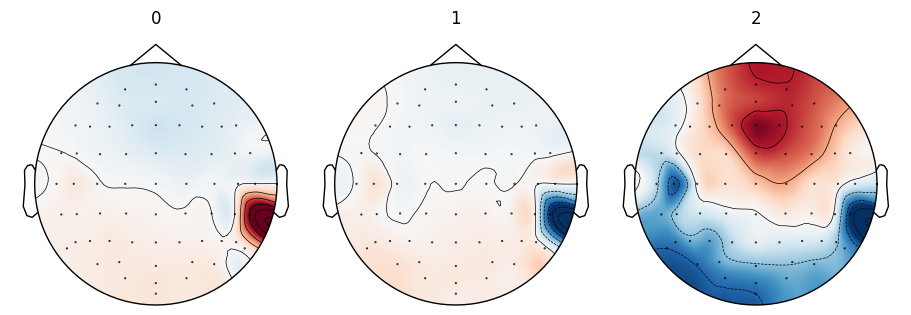

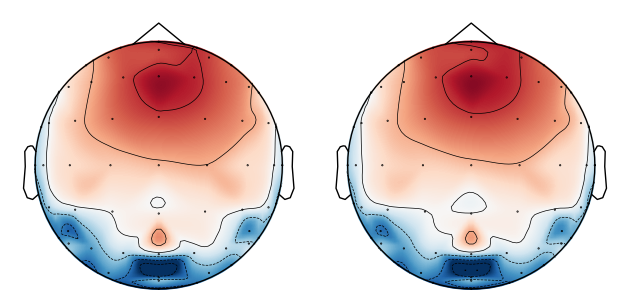

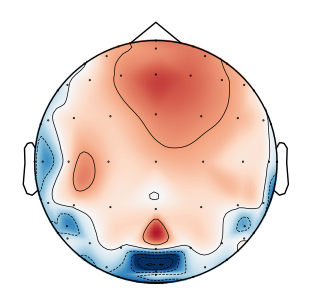

In [245]:
# -------------------------------
# Subject 05 — Cluster map vs. event maps vs. random map
# -------------------------------
ModK = ModK_dict["subject_05"]
ModK.plot()

# PLot HMP event 3 and 4 (corr of 0.94 and 0.95 with cluster map 2)
fig, axes = plt.subplots(1, 2)  

for ax, i in zip(axes, range(3, 5)):
    abs_place_event = event_abs_timing_list(eventprobs, i)
    avg_map = average_map_for_event(abs_place_event, epoch_data)

    mne.viz.plot_topomap(avg_map, positions, axes=ax, show=False)

plt.tight_layout()

# PLot of random average map (made by sampling from the whole data)
all_maps = []
random_timing = [np.random.randint(0, round(rt * 1000 * 0.5)) for rt in epoch_data.rt.values]

for idx, sample_idx in enumerate(random_timing):
    values = epoch_data.isel(epochs=idx, samples=sample_idx).data.values[0]
    all_maps.append(values)

random_avg_map = np.mean(np.array(all_maps), axis=0)
mne.viz.plot_topomap(random_avg_map, positions, size=3)
plt.show()

### A closer look at subject 17

In [246]:
model = models_third_session["subject_17"]["model"]
eventprobs = model.eventprobs.values
epoch_data = models_third_session["subject_17"]["epoch_data"]

In [247]:
# -------------------------------
# Subject 17 — Significant correlations
# -------------------------------
significance_df = significance_dict["subject_17"]
observed_corr_df = observed_corr_dict["subject_17"]

# Boolean mask for significance
significance_bool_df = significance_df <= 0.05

# Extract significant correlations
significant_correlations = observed_corr_df[significance_bool_df]

print("📊 Significant Correlations for Subject 17:")
print(significant_correlations)

📊 Significant Correlations for Subject 17:
            event_0   event_1   event_2   event_3   event_4   event_5  \
cluster_0  0.688331 -0.776578 -0.870589 -0.883654 -0.858996  0.606895   
cluster_1       NaN       NaN       NaN       NaN       NaN       NaN   
cluster_2       NaN       NaN       NaN       NaN       NaN       NaN   

            event_6  
cluster_0 -0.317043  
cluster_1       NaN  
cluster_2       NaN  


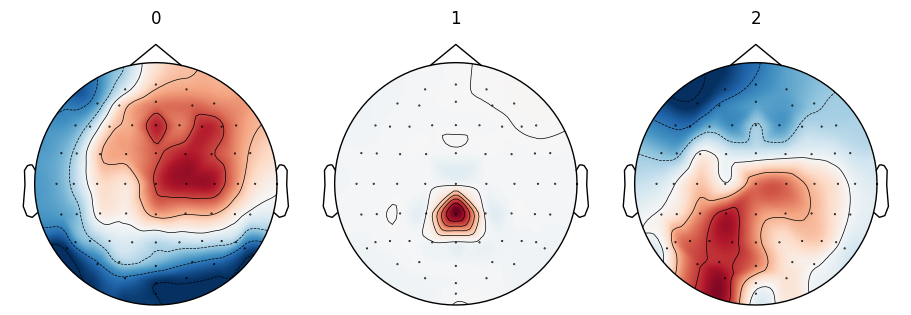

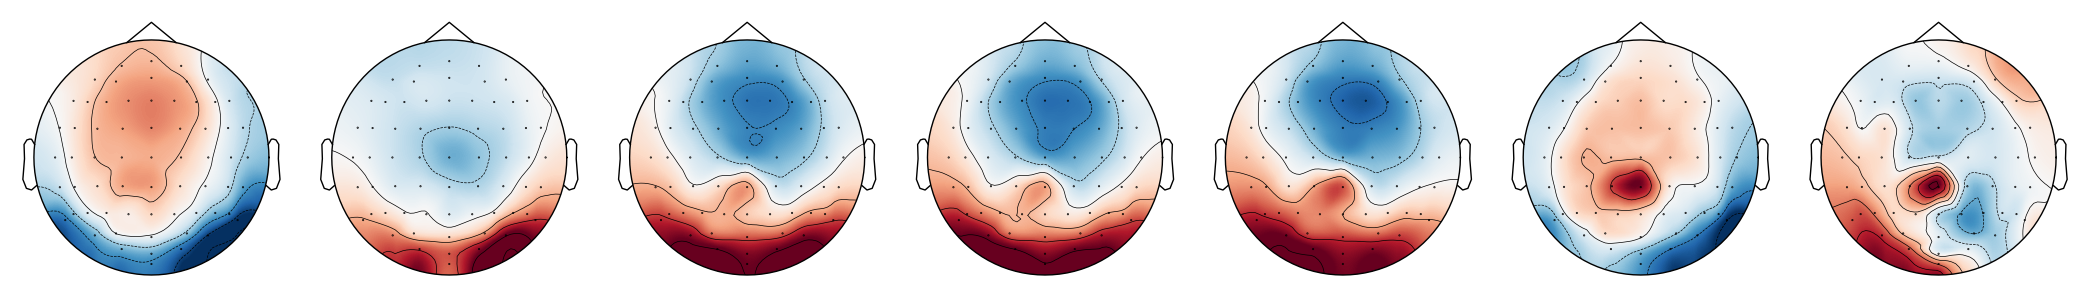

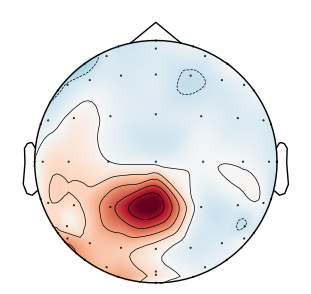

In [249]:
# -------------------------------
# Subject 17 — Cluster map vs. event maps vs. random map
# -------------------------------
ModK = ModK_dict["subject_17"]
ModK.plot()

###
# Number of events to plot
n_events = 7

# Prepare figure
fig, axes = plt.subplots(1, n_events, figsize=(3 * n_events, 3))

# Loop through events and plot each topomap
for i in range(n_events):
    abs_place_event = event_abs_timing_list(eventprobs, i)
    avg_map = average_map_for_event(abs_place_event,epoch_data)

    # Plot to the corresponding subplot axis
    mne.viz.plot_topomap(avg_map, info, axes=axes[i], show=False)

plt.tight_layout()


# PLot of random average map (made by sampling from the whole data)
all_maps = []
random_timing = [np.random.randint(0, round(rt * 1000 * 0.5)) for rt in epoch_data.rt.values]

for idx, sample_idx in enumerate(random_timing):
    values = epoch_data.isel(epochs=idx, samples=sample_idx).data.values[0]
    all_maps.append(values)

random_avg_map = np.mean(np.array(all_maps), axis=0)
mne.viz.plot_topomap(random_avg_map, positions, size=3)
plt.show()